In [21]:
# ============================================================
# FICO Quantization + Rating Map + Monte Carlo Risk Model
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import norm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from matplotlib.animation import FuncAnimation


warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

sns.set_style("whitegrid")

In [2]:
# ------------------------------------------------------------
# 1. LOAD DATA
# ------------------------------------------------------------
df = pd.read_csv("Downloads/Task 3 and 4_Loan_Data.csv")

# Assume last column is default indicator (0/1)
target_col = df.columns[-1]

X = df.drop(columns=[target_col])
y = df[target_col]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])
# Assume FICO column exists
fico_col = [col for col in df.columns if "fico" in col.lower()][0]
target_col = df.columns[-1]   # default column

df = df[[fico_col, target_col]].dropna()

df.columns = ["FICO", "Default"]

print("Dataset Shape:", df.shape)

Dataset Shape: (10000, 2)


In [3]:
df.head()

,FICO,Default
0,605,0
1,572,1
2,602,0
3,612,0
4,631,0


In [4]:
# ------------------------------------------------------------
# 2. MSE-Based Quantization (Equal Frequency Buckets)
# ------------------------------------------------------------

n_buckets = 5

df["Bucket"] = pd.qcut(df["FICO"], q=n_buckets, duplicates="drop")

bucket_stats = df.groupby("Bucket").agg(
    Count=("Default", "count"),
    Defaults=("Default", "sum")
)

bucket_stats["PD"] = bucket_stats["Defaults"] / bucket_stats["Count"]

print(bucket_stats)


                  Count  Defaults        PD
Bucket                                     
(407.999, 587.0]   2050       817  0.398537
(587.0, 623.0]     1971       425  0.215627
(623.0, 653.0]     1989       301  0.151332
(653.0, 688.0]     1997       200  0.100150
(688.0, 850.0]     1993       108  0.054190


In [5]:
# ------------------------------------------------------------
# 3. Rating Map (Lower Rating = Better Credit)
# ------------------------------------------------------------

bucket_stats = bucket_stats.sort_index(ascending=False)

bucket_stats["Rating"] = range(1, len(bucket_stats)+1)

print(bucket_stats)


                  Count  Defaults        PD  Rating
Bucket                                             
(688.0, 850.0]     1993       108  0.054190       1
(653.0, 688.0]     1997       200  0.100150       2
(623.0, 653.0]     1989       301  0.151332       3
(587.0, 623.0]     1971       425  0.215627       4
(407.999, 587.0]   2050       817  0.398537       5


In [6]:
# ------------------------------------------------------------
# 4. Log-Likelihood Calculation
# ------------------------------------------------------------

log_likelihood = 0

for i in bucket_stats.index:
    ni = bucket_stats.loc[i, "Count"]
    ki = bucket_stats.loc[i, "Defaults"]
    pi = bucket_stats.loc[i, "PD"]

    if pi > 0 and pi < 1:
        log_likelihood += ki*np.log(pi) + (ni-ki)*np.log(1-pi)

print("Log-Likelihood:", round(log_likelihood,2))


Log-Likelihood: -4321.03


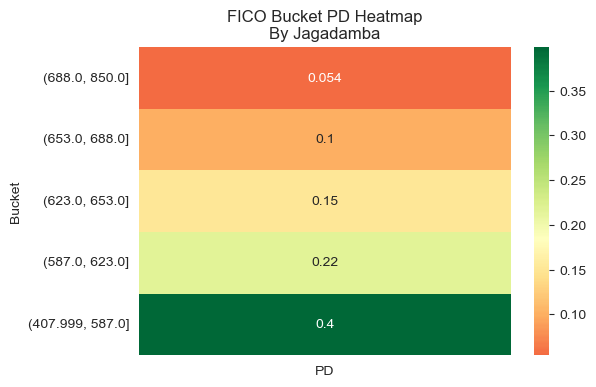

In [7]:
# ------------------------------------------------------------
# 5. Heatmap of PD per Bucket
# ------------------------------------------------------------

plt.figure(figsize=(6,4))
sns.heatmap(
    bucket_stats[["PD"]],
    annot=True,
    cmap="RdYlGn",
    center=bucket_stats["PD"].mean()
)

plt.title("FICO Bucket PD Heatmap\nBy Jagadamba")
plt.show()


In [8]:
# ------------------------------------------------------------
# 6. Monte Carlo Portfolio Loss Simulation
# ------------------------------------------------------------

EAD = 100000
LGD = 0.6
simulations = 5000

pd_values = bucket_stats["PD"].values

portfolio_losses = []

for _ in range(simulations):
    simulated_defaults = np.random.binomial(1, np.repeat(pd_values, bucket_stats["Count"]))
    loss = np.sum(simulated_defaults) * LGD * EAD
    portfolio_losses.append(loss)

portfolio_losses = np.array(portfolio_losses)

expected_loss = np.mean(portfolio_losses)
var_95 = np.percentile(portfolio_losses, 95)

print("Expected Loss:", round(expected_loss,2))
print("95% VaR:", round(var_95,2))


Expected Loss: 111095748.0
95% VaR: 114780000.0


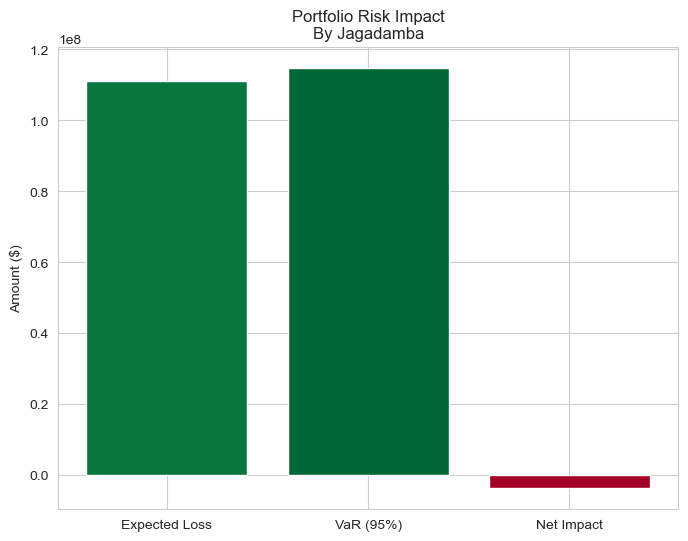

In [9]:
# ------------------------------------------------------------
# 7. Bar Chart – Expected vs VaR vs Loss
# ------------------------------------------------------------

values = [expected_loss, var_95, expected_loss - var_95]
labels = ["Expected Loss", "VaR (95%)", "Net Impact"]

norm_vals = plt.Normalize(min(values), max(values))
colors = plt.cm.RdYlGn(norm_vals(values))

plt.figure(figsize=(8,6))
plt.bar(labels, values, color=colors)
plt.title("Portfolio Risk Impact\nBy Jagadamba")
plt.ylabel("Amount ($)")
plt.show()


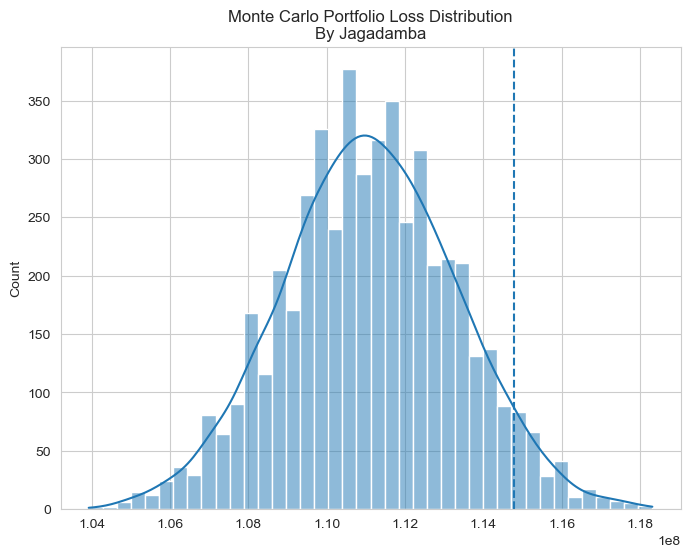

In [10]:
# ------------------------------------------------------------
# 8. Portfolio Loss Distribution
# ------------------------------------------------------------

plt.figure(figsize=(8,6))
sns.histplot(portfolio_losses, bins=40, kde=True)
plt.axvline(var_95, linestyle="--")
plt.title("Monte Carlo Portfolio Loss Distribution\nBy Jagadamba")
plt.show()


KS Statistic: 0.0191


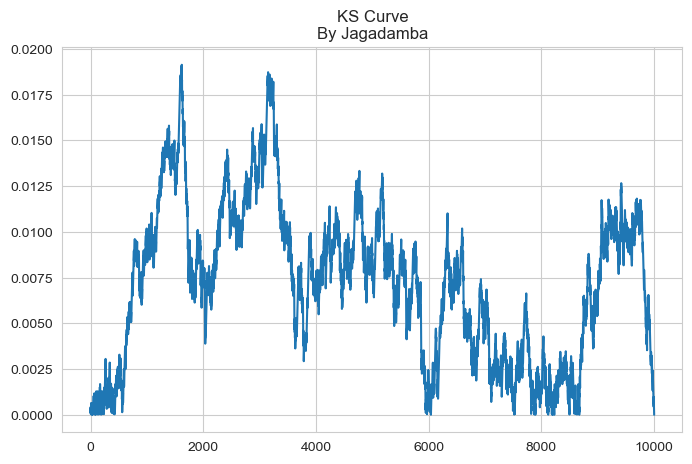

In [11]:
# ------------------------------------------------------------
# 9. KS Statistic Optimization
# ------------------------------------------------------------

df["Cumulative_Bad"] = df["Default"].cumsum()
df["Cumulative_Good"] = ((df["Default"]==0).cumsum())

total_bad = df["Default"].sum()
total_good = len(df) - total_bad

df["KS"] = abs(
    df["Cumulative_Bad"]/total_bad -
    df["Cumulative_Good"]/total_good
)

ks_value = df["KS"].max()
print("KS Statistic:", round(ks_value,4))

plt.figure(figsize=(8,5))
plt.plot(df["KS"])
plt.title("KS Curve\nBy Jagadamba")
plt.show()


In [12]:
# ------------------------------------------------------------
# 10. WOE & IV Calculation
# ------------------------------------------------------------

bucket_stats["Good"] = bucket_stats["Count"] - bucket_stats["Defaults"]

total_good = bucket_stats["Good"].sum()
total_bad = bucket_stats["Defaults"].sum()

bucket_stats["Dist_Good"] = bucket_stats["Good"] / total_good
bucket_stats["Dist_Bad"] = bucket_stats["Defaults"] / total_bad

bucket_stats["WOE"] = np.log(
    (bucket_stats["Dist_Good"] + 1e-6) /
    (bucket_stats["Dist_Bad"] + 1e-6)
)

bucket_stats["IV"] = (
    bucket_stats["Dist_Good"] -
    bucket_stats["Dist_Bad"]
) * bucket_stats["WOE"]

print("Information Value:", round(bucket_stats["IV"].sum(),4))
print(bucket_stats[["WOE","IV"]])


Information Value: 0.6474
                       WOE        IV
Bucket                              
(688.0, 850.0]    1.377370  0.238244
(653.0, 688.0]    0.713383  0.080233
(623.0, 653.0]    0.242019  0.010776
(587.0, 623.0]   -0.190831  0.007612
(407.999, 587.0] -1.070598  0.310555


In [13]:
# ------------------------------------------------------------
# 11. Basel IRB Capital Calculation
# ------------------------------------------------------------

EAD = 100000
LGD = 0.6
R = 0.12
confidence = 0.999

pd_mean = bucket_stats["PD"].mean()
pd_safe = np.clip(pd_mean, 1e-6, 1-1e-6)

capital = (
    LGD *
    (
        norm.cdf(
            (norm.ppf(pd_safe) +
             np.sqrt(R)*norm.ppf(confidence)) /
            np.sqrt(1-R)
        )
        - pd_safe
    )
) * EAD

print("Basel Capital Requirement:", round(capital,2))


Basel Capital Requirement: 23279.61


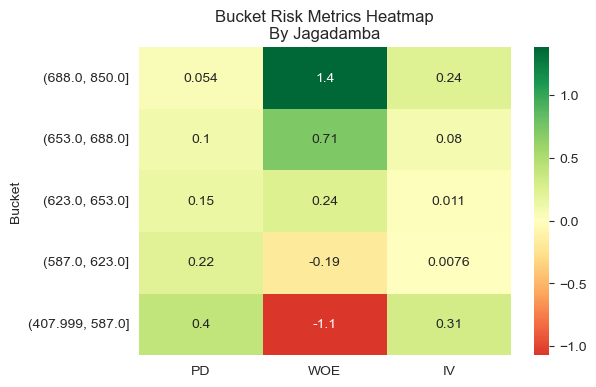

In [14]:
# ------------------------------------------------------------
# 12. Heatmap Visualization
# ------------------------------------------------------------


plt.figure(figsize=(6,4))
sns.heatmap(
    bucket_stats[["PD","WOE","IV"]],
    annot=True,
    cmap="RdYlGn",
    center=0
)

plt.title("Bucket Risk Metrics Heatmap\nBy Jagadamba")
plt.show()


In [15]:
# ------------------------------------------------------------
# 13. Generate Original Signal
# ------------------------------------------------------------

t = np.linspace(0, 10, 500)
original_signal = 2*np.sin(2*np.pi*0.5*t) + 0.8*np.sin(2*np.pi*1.2*t)


In [16]:
# ------------------------------------------------------------
# 14. Quantization Function
# ------------------------------------------------------------

def quantize(signal, levels):
    min_val = np.min(signal)
    max_val = np.max(signal)
    step = (max_val - min_val) / levels
    quantized = np.round((signal - min_val)/step) * step + min_val
    return quantized

levels = 15
quantized_signal = quantize(original_signal, levels)


In [17]:
# ------------------------------------------------------------
# 15. Quantization Noise
# ------------------------------------------------------------

quantization_noise = original_signal - quantized_signal

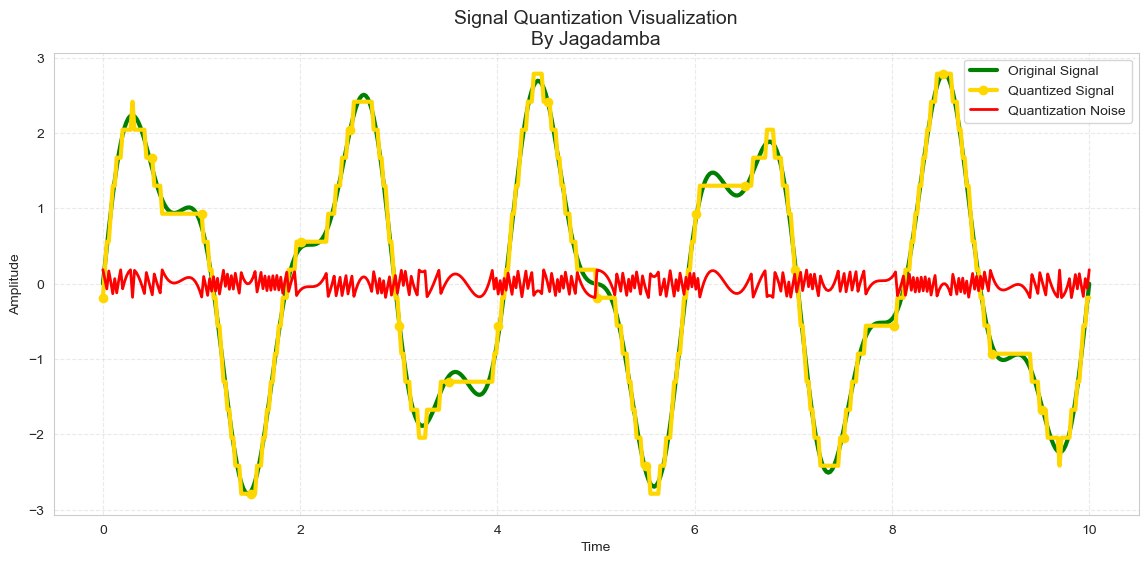

In [18]:
# ------------------------------------------------------------
# 16. Plot Graph (Like Your Image)
# ------------------------------------------------------------

plt.figure(figsize=(14,6))

# Original signal
plt.plot(t, original_signal, 
         color="green", linewidth=3, label="Original Signal")

# Quantized signal
plt.plot(t, quantized_signal, 
         color="gold", linewidth=3, marker='o', markevery=25,
         label="Quantized Signal")

# Noise
plt.plot(t, quantization_noise, 
         color="red", linewidth=2, label="Quantization Noise")

plt.grid(True, linestyle='--', alpha=0.4)
plt.title("Signal Quantization Visualization\nBy Jagadamba", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [22]:
class QuantizationAnalyzer:
    
    def __init__(self, signal, bits):
        self.signal = signal
        self.bits = bits
        self.levels = 2 ** bits
        self.quantized_signal = self._quantize()
        self.noise = self.signal - self.quantized_signal
        
    # --------------------------------------------------------
    # Quantization
    # --------------------------------------------------------
    def _quantize(self):
        min_val = np.min(self.signal)
        max_val = np.max(self.signal)
        step = (max_val - min_val) / self.levels
        quantized = np.round((self.signal - min_val)/step) * step + min_val
        return quantized
    
    # --------------------------------------------------------
    # MSE
    # --------------------------------------------------------
    def mse(self):
        return np.mean(self.noise**2)
    
    # --------------------------------------------------------
    # SNR
    # --------------------------------------------------------
    def snr(self):
        signal_power = np.mean(self.signal**2)
        noise_power = np.mean(self.noise**2)
        return 10 * np.log10(signal_power / noise_power)
    
    # --------------------------------------------------------
    # Plot Signals
    # --------------------------------------------------------
    def plot_signals(self):
        plt.figure(figsize=(12,6))
        plt.plot(self.signal, color="green", linewidth=2, label="Original Signal")
        plt.plot(self.quantized_signal, color="gold", linewidth=2, label="Quantized Signal")
        plt.plot(self.noise, color="red", linewidth=1.5, label="Quantization Noise")
        plt.title(f"Quantization ({self.bits}-bit)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.show()
    
    # --------------------------------------------------------
    # Error Histogram
    # --------------------------------------------------------
    def plot_error_histogram(self):
        plt.figure(figsize=(8,5))
        plt.hist(self.noise, bins=30, edgecolor="black")
        plt.title("Quantization Error Histogram")
        plt.xlabel("Error")
        plt.ylabel("Frequency")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.show()
    
    # --------------------------------------------------------
    # Animated Quantization Effect
    # --------------------------------------------------------
    def animate_quantization(self):
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_title(f"Animated Quantization ({self.bits}-bit)")
        ax.grid(True, linestyle='--', alpha=0.4)
        
        line_original, = ax.plot([], [], color="green", linewidth=2, label="Original")
        line_quantized, = ax.plot([], [], color="gold", linewidth=2, label="Quantized")
        ax.legend()
        
        def update(frame):
            line_original.set_data(np.arange(frame), self.signal[:frame])
            line_quantized.set_data(np.arange(frame), self.quantized_signal[:frame])
            ax.set_xlim(0, len(self.signal))
            ax.set_ylim(min(self.signal)-1, max(self.signal)+1)
            return line_original, line_quantized
        
        ani = FuncAnimation(fig, update, frames=len(self.signal), interval=10)
        plt.show()

2-bit MSE: 0.0784051447904094
2-bit SNR: 14.325798614485784
4-bit MSE: 0.007147484201079239
4-bit SNR: 24.727712185531416
8-bit MSE: 2.8024809300095836e-05
8-bit SNR: 48.79381756570916


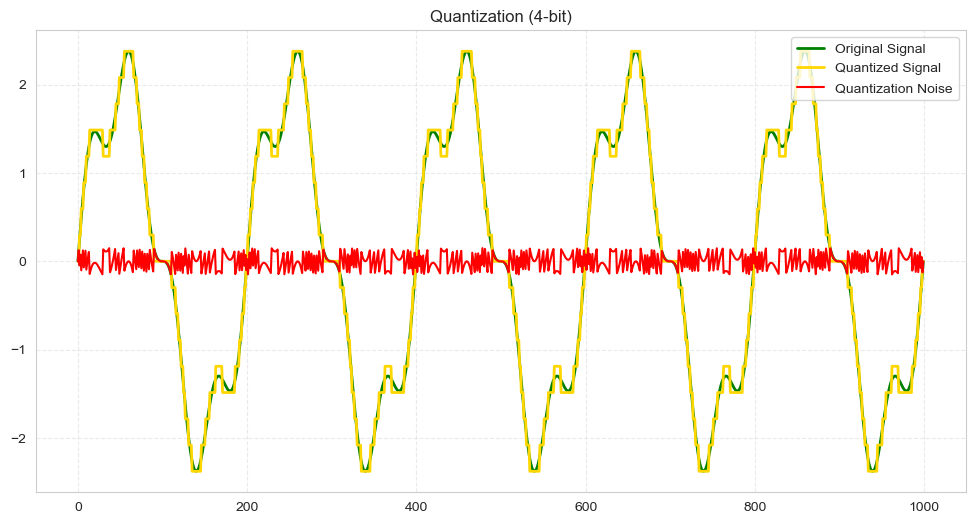

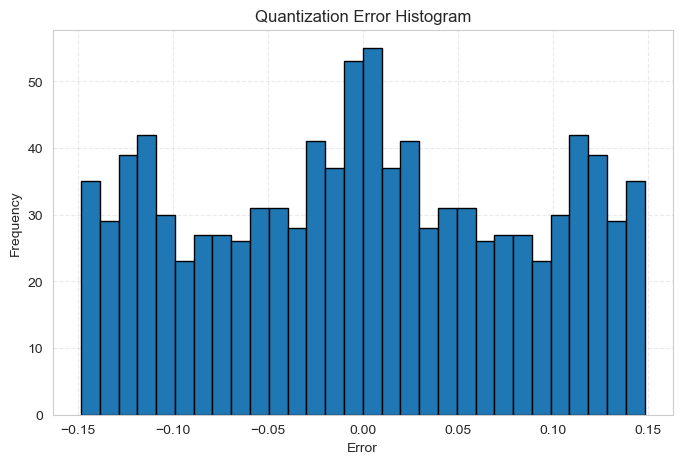

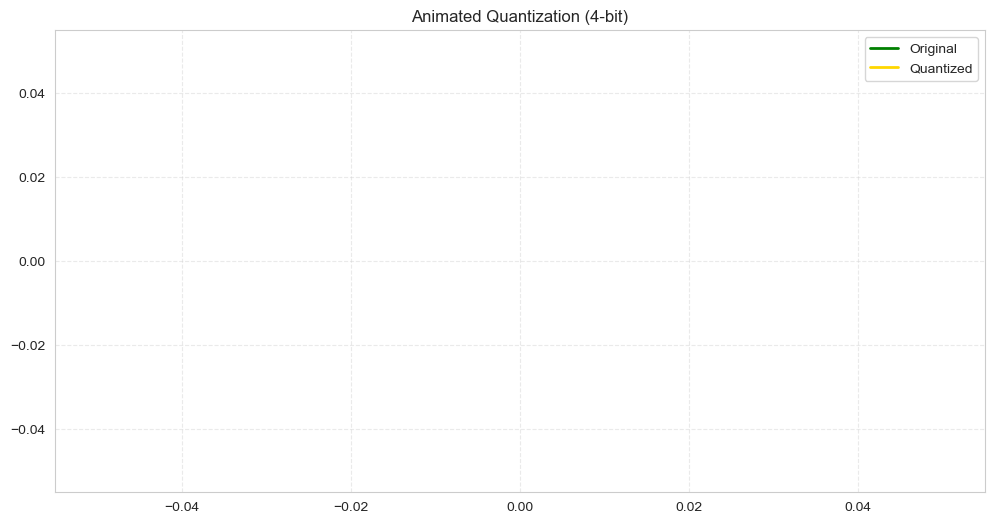

In [23]:
# ------------------------------------------------------------
# Generate Sample Signal
# ------------------------------------------------------------
t = np.linspace(0, 10, 1000)
signal = 2*np.sin(2*np.pi*0.5*t) + 0.5*np.sin(2*np.pi*2*t)

# ------------------------------------------------------------
# Try Different Bit Depths
# ------------------------------------------------------------

qa_2bit = QuantizationAnalyzer(signal, bits=2)
qa_4bit = QuantizationAnalyzer(signal, bits=4)
qa_8bit = QuantizationAnalyzer(signal, bits=8)

print("2-bit MSE:", qa_2bit.mse())
print("2-bit SNR:", qa_2bit.snr())

print("4-bit MSE:", qa_4bit.mse())
print("4-bit SNR:", qa_4bit.snr())

print("8-bit MSE:", qa_8bit.mse())
print("8-bit SNR:", qa_8bit.snr())

qa_4bit.plot_signals()
qa_4bit.plot_error_histogram()

# Animate
qa_4bit.animate_quantization()


In [24]:
# ============================================================
# Task 4: Optimal FICO Bucket Quantization
# MSE + Log-Likelihood + Dynamic Programming
# Created for Charlie
# ============================================================

import numpy as np
import pandas as pd

class FICOQuantizer:
    
    def __init__(self, df, fico_col, default_col):
        self.df = df[[fico_col, default_col]].dropna().copy()
        self.df.columns = ["FICO", "Default"]
        self.df = self.df.sort_values("FICO").reset_index(drop=True)
    
    # --------------------------------------------------------
    # MSE COST FUNCTION
    # --------------------------------------------------------
    def mse_cost(self, data):
        mean_value = data["FICO"].mean()
        return np.sum((data["FICO"] - mean_value) ** 2)
    
    # --------------------------------------------------------
    # LOG-LIKELIHOOD COST FUNCTION
    # --------------------------------------------------------
    def log_likelihood(self, data):
        n = len(data)
        k = data["Default"].sum()
        if n == 0:
            return -np.inf
        p = k / n
        if p == 0 or p == 1:
            return 0
        return k*np.log(p) + (n-k)*np.log(1-p)
    
    # --------------------------------------------------------
    # DYNAMIC PROGRAMMING OPTIMIZATION
    # --------------------------------------------------------
    def optimal_binning(self, n_bins, method="loglik"):
        N = len(self.df)
        dp = np.full((N+1, n_bins+1), -np.inf)
        split = np.zeros((N+1, n_bins+1))
        
        dp[0][0] = 0
        
        for i in range(1, N+1):
            for k in range(1, n_bins+1):
                for j in range(k-1, i):
                    if method == "mse":
                        score = dp[j][k-1] - self.mse_cost(self.df.iloc[j:i])
                    else:
                        score = dp[j][k-1] + self.log_likelihood(self.df.iloc[j:i])
                    
                    if score > dp[i][k]:
                        dp[i][k] = score
                        split[i][k] = j
        
        # Backtrack to find boundaries
        bins = []
        i = N
        k = n_bins
        while k > 0:
            j = int(split[i][k])
            bins.append((j, i))
            i = j
            k -= 1
        
        bins.reverse()
        return bins
    
    # --------------------------------------------------------
    # CREATE RATING MAP
    # --------------------------------------------------------
    def create_rating_map(self, bins):
        rating_map = []
        
        for idx, (start, end) in enumerate(bins):
            bucket = self.df.iloc[start:end]
            min_score = bucket["FICO"].min()
            max_score = bucket["FICO"].max()
            pd_bucket = bucket["Default"].mean()
            
            rating_map.append({
                "Rating": idx + 1,   # Lower rating = better score
                "Min_FICO": min_score,
                "Max_FICO": max_score,
                "PD": round(pd_bucket, 4)
            })
        
        rating_df = pd.DataFrame(rating_map)
        rating_df = rating_df.sort_values("Min_FICO", ascending=False)
        rating_df["Rating"] = range(1, len(rating_df)+1)
        
        return rating_df


In [ ]:


fico_col = [c for c in df.columns if "fico" in c.lower()][0]
default_col = df.columns[-1]

quantizer = FICOQuantizer(df, fico_col, default_col)

# ------------------------------------------------------------
# MSE-Based Bucketing
# ------------------------------------------------------------
mse_bins = quantizer.optimal_binning(n_bins=5, method="mse")
mse_rating_map = quantizer.create_rating_map(mse_bins)

print("MSE Rating Map")
print(mse_rating_map)

# ------------------------------------------------------------
# Log-Likelihood Bucketing (Recommended)
# ------------------------------------------------------------
ll_bins = quantizer.optimal_binning(n_bins=5, method="loglik")
ll_rating_map = quantizer.create_rating_map(ll_bins)

print("\nLog-Likelihood Rating Map")
print(ll_rating_map)
